Very messy implementation of https://arxiv.org/pdf/2410.10103

Attempting to reproduce Lorenz'96 analysis, with deep learning extension to learn the coordinate transforms.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import diffrax
import optax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

from src.generator import lorenz96
from src.koopman import *
from src.nn import *

# Causal Koopman

### Causal dependence with cumulative neighborhood shifts

We evaluate the spatial dependence. We attempt to reproduce Figures 7, 8 of the paper for Lorenz'96 dynamics.

In [3]:
# Integration
t0, t1 = 0.0, 10.0
dt = 0.001
steps = int((t1 - t0) / dt)

N = 101  # Number of sites / 'oscillators'
F = 4.0 
initial_state = F + jax.random.normal(jax.random.PRNGKey(42), shape=(N,))

# Solve the system
solver = diffrax.Dopri5()  # Runge-Kutta solver
solution = diffrax.diffeqsolve(
    diffrax.ODETerm(lorenz96),
    solver=solver,
    t0=t0,
    t1=t1,
    dt0=dt,
    y0=initial_state,
    args=(F,),
    saveat=diffrax.SaveAt(ts=jnp.linspace(t0, t1, min(4000, steps))),
    max_steps=100000
)

# Extract results
omega = solution.ys.T


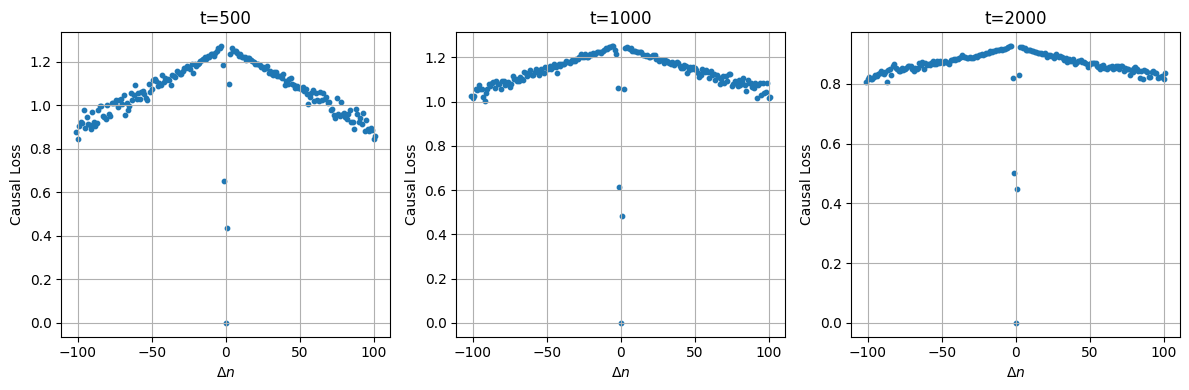

In [4]:
# Causal effect (cumulative neighborhood effect)
center_idx = 51
neighborhood_range = range(-N, N+1)
t_shifts = [500, 1000, 2000]

f, ax = plt.subplots(1, len(t_shifts), figsize=(12,4))

for i, t_shift in enumerate(t_shifts):
    
    # Effect
    effect = omega[center_idx:center_idx+1, :]

    # Compute causal loss with varying neighborhood ranges
    causal_losses = []
    
    for delta_n in neighborhood_range:
        
        ## Cause (cumulative neighborhood)
        if delta_n < 0:
            neighbor_indices = [(center_idx + i) % N for i in range(delta_n, 0)]
        
        else:
            neighbor_indices = [(center_idx + i) % N for i in range(1, delta_n + 1)]
    
        cause = omega[neighbor_indices, :]

        ## Compute causal loss
        causal_loss, _, _ = compute_causal_loss(
            cause, 
            effect, 
            t = t_shift
        )
        
        causal_losses.append(causal_loss)
    
    # Plot
    ax[i].scatter(neighborhood_range, causal_losses, s=10)
    ax[i].set_title(f't={int(t_shift)}')
    ax[i].grid()
    ax[i].set_xlabel(r"$\Delta n$")
    ax[i].set_ylabel("Causal Loss")

plt.tight_layout()
plt.show();


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:35<00:00,  1.14it/s]


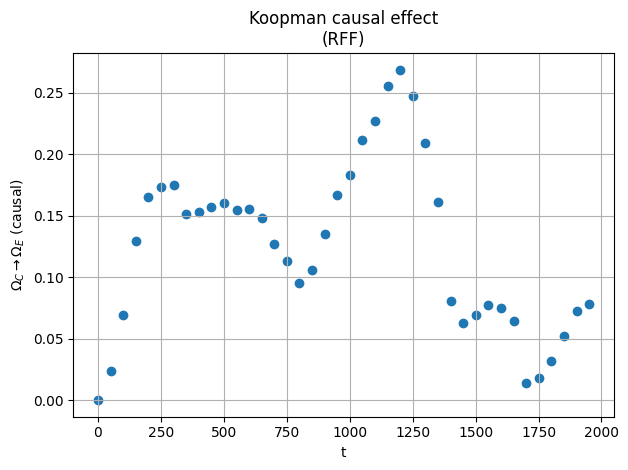

In [5]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

cause = omega[center_idx-3:center_idx, :]
effect = omega[center_idx:center_idx+3, :]

for t in tqdm(time_shifts):
    causal_loss, _, _ = compute_causal_loss(
        cause=cause, 
        effect=effect,
        t=t
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

plt.title('Koopman causal effect\n(RFF)')
plt.grid()
plt.tight_layout()
plt.show;

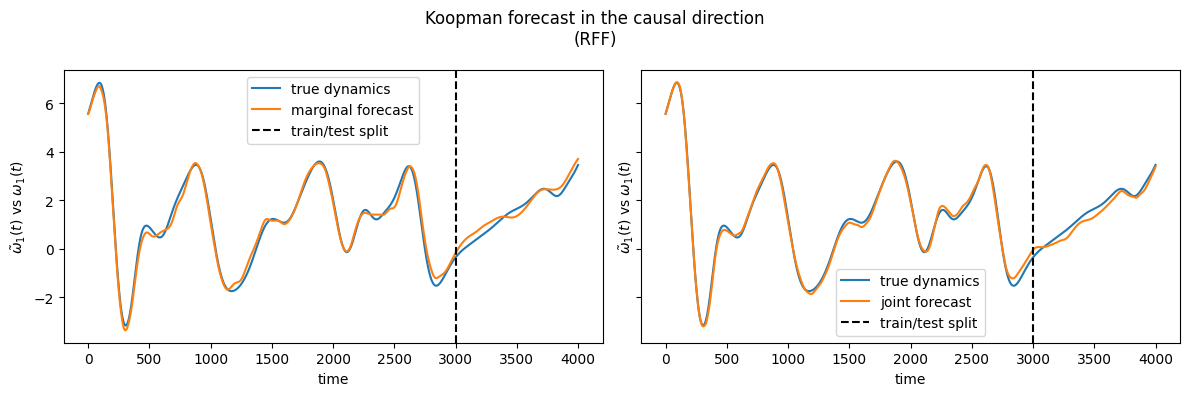

In [6]:
# Conditional inference (causal)
cause = omega[center_idx-3:center_idx, :]
effect = omega[center_idx:center_idx+3, :]
n_train = 3000

omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    t = 1
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction\n(RFF)')
plt.tight_layout()
plt.show();


# Deep Causal Koopman
Using neural network to approximate the lifting operators, i.e., y(t) = f[x(t)], where x(t) is the high-dimensional non-linear states.

In [7]:
# Hyperparameters
t = 1
hidden_dims = [6,12]
lr = 1e-3
epochs = 1000

In [8]:
@jax.jit
def loss_fn(model, x, y):
    """Reconstruction loss."""
    y_pred = model.decoder(model.encoder(x))
    return jnp.mean(jnp.square(y_pred - y))

@jax.jit
def train_step(model, opt_state, x, y):
    """Autograd routine."""
    loss, grads = jax.value_and_grad(loss_fn)(model, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


def train_model(model, x, y, n_train, epochs, lr, t=1):
    """Utility function for training."""
    opt_state = optimizer.init(model)
    x, y = x[:, :n_train], y[:, :n_train]
    
    losses = []
    for epoch in range(epochs):
        model, opt_state, loss = train_step(
            model, opt_state, 
            x = x[:, :-t], y = y[:, :-t]
        )
        
        losses.append(loss)

    return model, losses

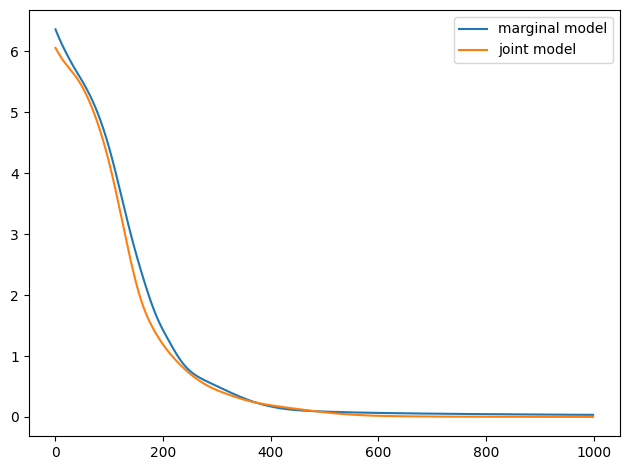

In [9]:
# Construct dataset
cause = omega[center_idx-3:center_idx, :]
effect = omega[center_idx:center_idx+3, :]
effect_cause = jnp.concatenate([effect, cause], axis=0)

# Define model
optimizer = optax.adamw(learning_rate=lr)
marginal_model = NNTransformModel(input_dim=effect.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])
joint_model = NNTransformModel(input_dim=effect_cause.shape[0], hidden_dims=hidden_dims, output_dim=effect.shape[0])

# Fit models
marginal_model, marginal_loss = train_model(
    marginal_model, x=effect, y=effect, n_train=n_train, epochs=epochs, lr=lr, t=1
)

joint_model, joint_loss = train_model(
    joint_model, x=effect_cause, y=effect, n_train=n_train, epochs=epochs, lr=lr, t=1
)

# Plot loss
plt.plot(marginal_loss, label='marginal model')
plt.plot(joint_loss, label='joint model')
plt.legend()
plt.tight_layout()
plt.show();

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:11<00:00,  3.35it/s]


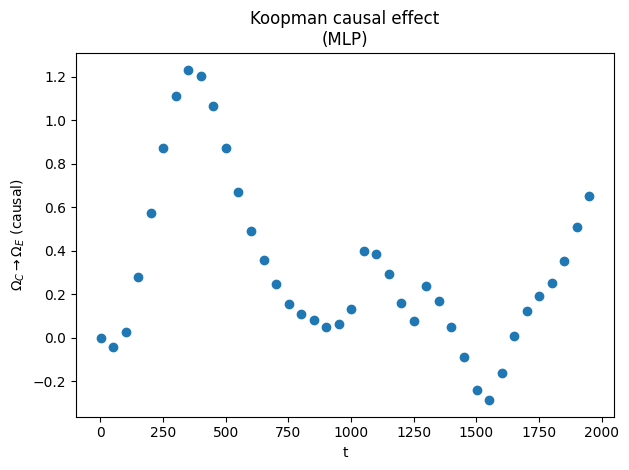

In [10]:
# Causal and non-causal direction (estimated by the causal loss)
time_shifts = jnp.arange(1, 2000, 50)
losses = {'causal': [], 'non_causal': []}

for t in tqdm(time_shifts):
    
    causal_loss, _, _ = compute_causal_loss(
        cause = cause, 
        effect = effect,
        t = t,
        marginal_model = marginal_model,
        joint_model = joint_model
    )
    
    losses['causal'].append(causal_loss)

# Plot
plt.scatter(time_shifts, losses['causal'])
plt.xlabel('t')
plt.ylabel(r'$\Omega_C \rightarrow \Omega_E$ (causal)')

plt.title('Koopman causal effect\n(MLP)')
plt.tight_layout()
plt.show;

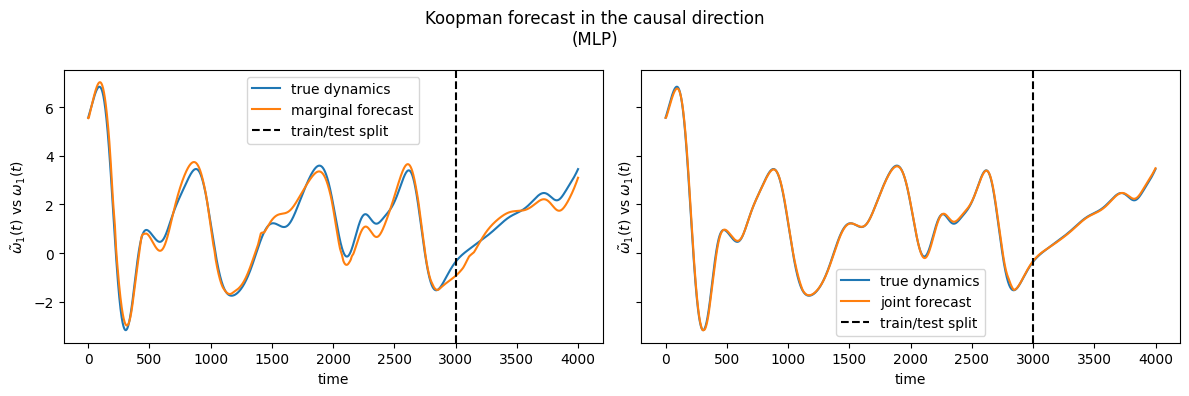

In [11]:
# Conditional inference (causal)
omega_marginal, omega_joint = conditional_forecasting(
    cause = cause, 
    effect = effect, 
    t = 1,
    marginal_model = marginal_model,
    joint_model = joint_model
)

# Plot
param_id = 0

f, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
ax[0].plot(effect[param_id], label='true dynamics')
ax[0].plot(omega_marginal[param_id], label='marginal forecast')
ax[0].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[0].set_xlabel('time')
ax[0].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[0].legend()

ax[1].plot(effect[param_id], label='true dynamics')
ax[1].plot(omega_joint[param_id], label='joint forecast')
ax[1].axvline(n_train, color='black', linestyle='--', label='train/test split') 
ax[1].set_xlabel('time')
ax[1].set_ylabel(r'$\tilde{\omega}_1(t)$ vs $\omega_1(t)$')
ax[1].legend()

f.suptitle('Koopman forecast in the causal direction\n(MLP)')
plt.tight_layout()
plt.show();
